In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
path='/Users/kanishkbhagat/DS/Datasets/Computer Vision/Kidney 4 classes/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

classes=['Cyst','Normal','Stone','Tumor']

train,val=tf.keras.utils.image_dataset_from_directory(path,
                                            label_mode='int',
                                            class_names=classes,
                                            image_size=(224,224),
                                            seed=6,
                                            validation_split=0.1,
                                            subset='both',
                                            batch_size=None)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Using 1244 files for validation.


In [14]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [15]:
x_train=[]
y_train=[]
for x,y in train:
    x_train.append(x)
    y_train.append(y.numpy())

In [16]:
x_test=[]
y_test=[]
for x,y in val:
    x_test.append(x)
    y_test.append(y.numpy())

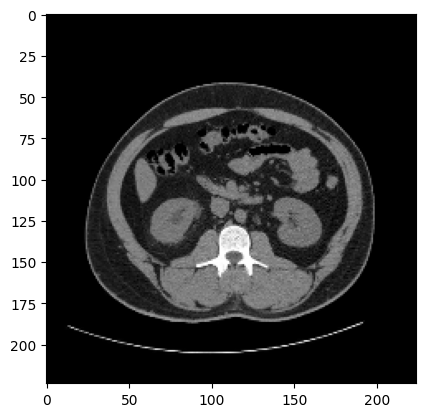

In [19]:
plt.imshow(x_train[1]/255)

In [20]:
x_train=np.array(x_train).astype('float32')
x_test=np.array(x_test).astype('float32')

y_train=np.array(y_train)
y_test=np.array(y_test)

mean=np.mean(x_train)
std=np.std(x_train)

X_train = (x_train-mean)/(std+1e-7)
X_test  = (x_test-mean) /(std+1e-7)
print(mean,std)

36.552525 60.96154


In [21]:
print(f'Shape \n\nx_train : {x_train.shape},\ny_train : {y_train.shape},\nx_test  : {x_test.shape},\ny_test  : {y_test.shape}')

Shape 

x_train : (11202, 224, 224, 3),
y_train : (11202,),
x_test  : (1244, 224, 224, 3),
y_test  : (1244,)


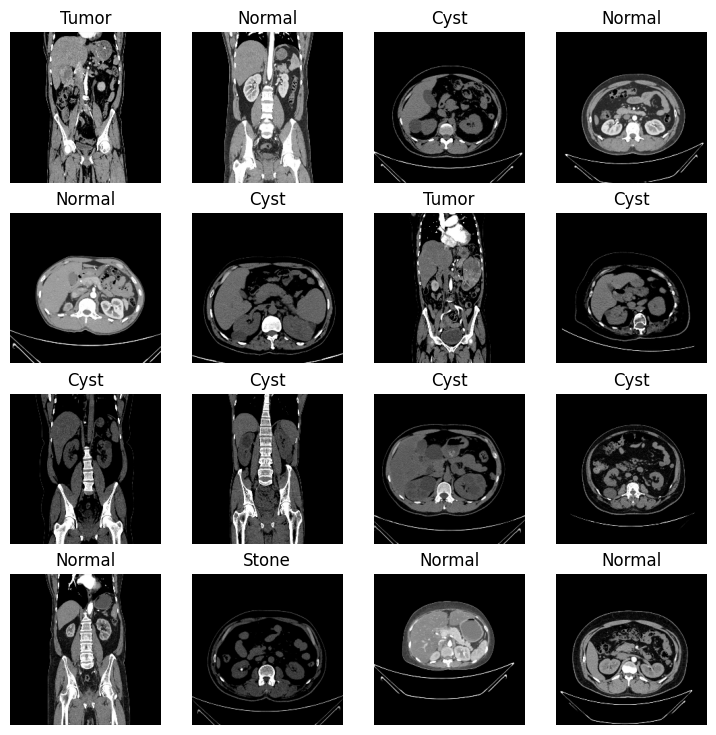

In [8]:
plt.figure(figsize=(9,9))
for i in range(16) :
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i]/255)
    plt.title(classes[y_train[i]])
    plt.axis('off')

In [9]:
# datagen=ImageDataGenerator(rotation_range=15,
#                    width_shift_range=0.1,
#                    brightness_range=[0.9,1.1],
#                    height_shift_range=0.1,
#                    shear_range=10,
#                    zoom_range=0.1,
#                    channel_shift_range=0.1
#                   )

In [22]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False,  
    weights='imagenet'
)

base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,924,436 (22.60 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
# cyst=3710
# normal=5078
# stone=1378
# tumor=2284

# # class_weight=Total/(no of classes * no of samples in class)
# no_of_classes=4

# total=3710 + 5078 + 1378 + 2284
# print('Total :', total)

# cyst_weight=total/(no_of_classes * cyst)
# print(f'cyst_weight : {cyst_weight:.4f}')

# normal_weight=total/(no_of_classes * normal)
# print(f'normal_weight : {normal_weight:.4f}')

# stone_weight=total/(no_of_classes * stone)
# print(f'stone_weight : {stone_weight:.4f}')

# tumor_weight=total/(no_of_classes * tumor)
# print(f'tumor_weight : {tumor_weight:.4f}')

Total : 12450
cyst_weight : 0.8389
normal_weight : 0.6129
stone_weight : 2.2587
tumor_weight : 1.3627


In [17]:
# reduce_lr=ReduceLROnPlateau(factor=0.5,
#                             patience=6,)

# early_stopping=EarlyStopping(patience=10,
#                              restore_best_weights=True,
#                              monitor='val_loss')

# checkpoint = ModelCheckpoint(
#     filepath='/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Kidney 4 classes/checkpoint_01//kidney_1_{epoch:02d}-{val_loss:.2f}.weights.h5',
#     monitor='val_loss',
#     save_best_only=False,
#     save_weights_only=True,
#     mode='min',
#     verbose=0)

# model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy',
#               tf.keras.metrics.AUC(multi_label=True)])

# history=model.fit(datagen.flow(x_train,y_train),
#           validation_data=(x_test,y_test),
#           epochs=200,
#           batch_size=32,
#           callbacks=[reduce_lr,early_stopping],
#           class_weight={'0':cyst_weight,
#                         '1':normal_weight,
#                         '2':stone_weight,
#                         '3':tumor_weight})

Epoch 1/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.9532 - auc_1: 0.9958 - loss: 0.1589 - val_accuracy: 0.9365 - val_auc_1: 0.9955 - val_loss: 0.1789 - learning_rate: 5.0000e-04
Epoch 2/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.9498 - auc_1: 0.9934 - loss: 0.1691 - val_accuracy: 0.9349 - val_auc_1: 0.9955 - val_loss: 0.1793 - learning_rate: 5.0000e-04
Epoch 3/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 157ms/step - accuracy: 0.9470 - auc_1: 0.9945 - loss: 0.1683 - val_accuracy: 0.9236 - val_auc_1: 0.9952 - val_loss: 0.2061 - learning_rate: 5.0000e-04
Epoch 4/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.9547 - auc_1: 0.9948 - loss: 0.1593 - val_accuracy: 0.9421 - val_auc_1: 0.9964 - val_loss: 0.1684 - learning_rate: 5.0000e-04
Epoch 5/200
351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 185ms/step - accuracy: 0.9550 - auc_1: 0.9953 - loss: 0.1551 - val_accuracy: 0.9220 - val_auc_1: 0.9945 - val_loss: 0.2098 - learning_rate: 5.0000e-04
Epoch 6/200
351/351 

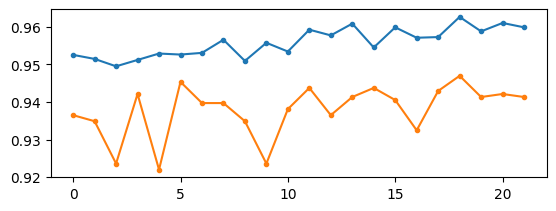

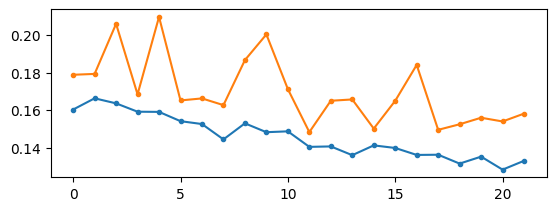

In [19]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'],marker='.')
plt.plot(history.history['val_accuracy'],marker='.')
plt.show()

plt.subplot(2,1,1)
plt.plot(history.history['loss'],marker='.')
plt.plot(history.history['val_loss'],marker='.')
plt.show()


In [20]:
#model.save('/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Kidney 4 classes/Saved Model/kidney_model.keras')

In [7]:
kidney_model=tf.keras.models.load_model('/Users/kanishkbhagat/Desktop/DS/Datasets/Computer Vision/Kidney 4 classes/Saved Model/kidney_model.keras')

kidney_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.AUC(multi_label=True)])

/Users/kanishkbhagat/ML/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 10 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/kanishkbhagat/ML/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
def predict(image):
    
    image=np.array(image)
    
    plt.imshow(image/255)
    plt.axis('off')
    
    image=np.expand_dims(image,axis=0)
    pred=kidney_model.predict(image)
    pred=np.argmax(pred,axis=1)[0]
    
    plt.title(f'Pred : {classes[pred]}')
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


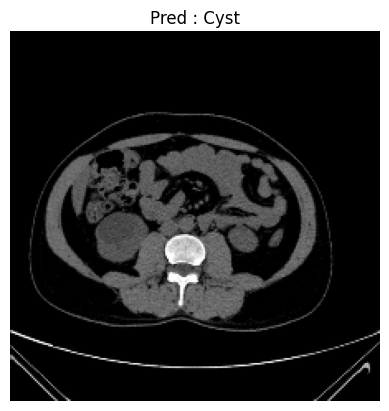

In [12]:
predict(x_test[500])

In [ ]:
plt.imshow